In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/home/gaddafi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os
PATH = os.getcwd()
numpy.random.seed(7)

In [3]:
PATH

'/home/gaddafi/SmartGrid'

In [4]:
df = pd.read_excel(PATH+'/data/final_data.xlsx')

In [5]:
df.head()

,Date,Hour,Market Demand,Ontario Demand,HOEP,BIOFUEL,GAS,HYDRO,NUCLEAR,SOLAR,WIND,TotalOutput,Company_HOEP
0,2018-01-01,1,18974,16627,51.29,3,1583,4152,11671,0,992,18401,310
1,2018-01-01,2,18447,16084,43.59,1,1192,4093,11672,0,1124,18082,27
2,2018-01-01,3,18453,15866,93.60,0,1040,4231,11672,0,1265,18208,87
3,2018-01-01,4,18662,15725,54.78,0,1041,3895,11669,0,1369,17974,65
4,2018-01-01,5,18060,15470,14.35,0,1004,3271,11674,0,1848,17797,194


In [6]:
data_X = df[['Ontario Demand', 'HOEP']]
dataset = data_X.values
dataset = dataset.astype('float32')

In [7]:
data_X.head()

,Ontario Demand,HOEP
0,16627,51.29
1,16084,43.59
2,15866,93.60
3,15725,54.78
4,15470,14.35


In [8]:
# normalize the dataset
scaler = MinMaxScaler()
print(dataset.shape)
dataset = scaler.fit_transform(dataset)

(8760, 2)


In [9]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5869 2891


In [10]:
test_hoep = test[:,1]
test_hoep = test_hoep.reshape(test_hoep.shape[0],1)
test_hoep.shape

(2891, 1)

In [11]:
dataset_hoep = dataset[:,1]
dataset_hoep = dataset_hoep.reshape(dataset_hoep.shape[0],1)

In [12]:
dataset_hoep.shape

(8760, 1)

In [13]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=48):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [14]:
# reshape into X=t and Y=t+48
look_back = 48
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [15]:
trainX[0:49]

array([[[0.4792503 , 0.15047428],
        [0.436491  , 0.12966517],
        [0.4193244 , 0.26481634],
        ...,
        [0.6516261 , 0.12439531],
        [0.57098985, 0.0335108 ],
        [0.5024017 , 0.0921817 ]],

       [[0.436491  , 0.12966517],
        [0.4193244 , 0.26481634],
        [0.40822113, 0.15990594],
        ...,
        [0.57098985, 0.0335108 ],
        [0.5024017 , 0.0921817 ],
        [0.45168912, 0.01810664]],

       [[0.4193244 , 0.26481634],
        [0.40822113, 0.15990594],
        [0.3881408 , 0.05064454],
        ...,
        [0.5024017 , 0.0921817 ],
        [0.45168912, 0.01810664],
        [0.41688323, 0.06437316]],

       ...,

       [[0.57098985, 0.0335108 ],
        [0.5024017 , 0.0921817 ],
        [0.45168912, 0.01810664],
        ...,
        [0.74328685, 0.17106721],
        [0.7335223 , 0.17082398],
        [0.7195054 , 0.1766073 ]],

       [[0.5024017 , 0.0921817 ],
        [0.45168912, 0.01810664],
        [0.41688323, 0.06437316],
        .

In [16]:
trainY.shape

(5820,)

In [17]:
trainX.shape

(5820, 48, 2)

In [25]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(30, return_sequences=True, input_shape=(look_back, 2)))
model.add(LSTM(30))
model.add(Dense(1))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=32, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 48, 30)            3960      
_________________________________________________________________
lstm_4 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 11,311
Trainable params: 11,311
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
 - 8s - loss: 0.0291
Epoch 2/20
 - 7s - loss: 0.0063
Epoch 3/20
 - 8s - loss: 0.0046
Epoch 4/20
 - 7s - loss: 0.0036
Epoch 5/20
 - 7s - loss: 0.0029
Epoch 6/20
 - 7s - loss: 0.0022
Epoch 7/20
 - 6s - loss: 0.0016
Epoch 8/20
 - 6s - loss: 0.0012
Epoch 9/20
 - 7s - loss: 8.6522e-04
Epoch 10/20
 - 6s - loss: 8.9414e-04
Epoch 11/20
 - 6s - loss: 7.2259e-04
Epoch 12/20
 - 6s - loss: 7.1037e-04

In [26]:
predicted_value= model.predict(testX)

In [27]:
from sklearn.metrics import mean_squared_error
mean_squared_error(testY,predicted_value)

0.00045365482

In [28]:
predicted_value.shape

(2842, 1)

In [29]:
testY.shape

(2842,)

In [30]:
import pickle
filename = 'finalized_model_2.sav'
pickle.dump(model, open(filename, 'wb'))

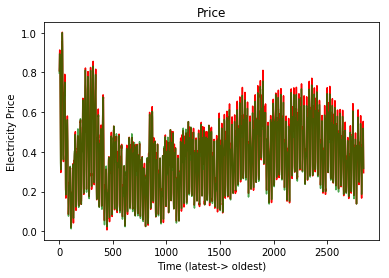

In [31]:
plt.plot(predicted_value, color= 'red')
plt.plot(testY, color='green',alpha=0.7)
plt.title("Price")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Electricity Price")
plt.show()

In [32]:
predicted_value = numpy.c_[predicted_value,test_hoep[look_back+1:,:]]

In [33]:
print(predicted_value.shape)
print(testX.shape)

(2842, 2)
(2842, 48, 2)


In [34]:
inverse_scaled_output = scaler.inverse_transform(predicted_value)
#inverse_scaled_actual = scaler.inverse_transform(testX)

In [35]:
testX[:,1].shape

(2842, 2)

In [36]:
predicted_value.shape

(2842, 2)

In [37]:
numpy.set_printoptions(suppress=True)
inverse_scaled_output

array([[20802.84   ,   136.95   ],
       [21044.28   ,   100.30999],
       [21687.865  ,    70.95   ],
       ...,
       [16023.337  ,     5.81   ],
       [15114.03   ,     2.87   ],
       [14286.881  ,     0.     ]], dtype=float32)

In [38]:
predictX, predictY = create_dataset(dataset, look_back)
predicted_dataset_value = model.predict(predictX)

In [39]:
predicted_dataset_value = numpy.c_[predicted_dataset_value,dataset_hoep[look_back+1:,:]]

In [40]:
print(predicted_dataset_value.shape)
print(predictX.shape)

(8711, 2)
(8711, 48, 2)


In [41]:
inverse_scaled_dataset_output = scaler.inverse_transform(predicted_dataset_value)
#inverse_scaled_actual = scaler.inverse_transform(testX)

In [42]:
numpy.set_printoptions(suppress=True)
inverse_scaled_dataset_output

array([[16385.408,    19.43 ],
       [15954.421,     0.   ],
       [15762.746,     0.   ],
       ...,
       [16023.339,     5.81 ],
       [15114.03 ,     2.87 ],
       [14286.881,     0.   ]], dtype=float32)

In [43]:
numpy.savetxt("full_values.csv", inverse_scaled_output, delimiter=",")

In [44]:
# import numpy as np
# x = np.array([[10,20,30], [40,50,60]])
# y = np.array([[100], [200]])
# print(np.append(x, y, axis=1))
# inverse_scaled_actual = scaler.inverse_transform(dataset[look_back:len(dataset)-1,:])
# inverse_scaled_actual[look_back:len(dataset)-1,0]

df2 = pd.read_excel(PATH+'/data/final_data.xlsx')
data_X2 = df2[['Ontario Demand', 'HOEP', 'Company_HOEP','Hour']]
dataset2 = data_X2.values
dataset2 = dataset2.astype('float32')
actual_demand2 = dataset2[look_back:len(dataset2)-1,0]

In [45]:
actual_demand2 = actual_demand2.reshape(len(dataset2)-48-1,1)

In [46]:
actual_demand2

array([[16277.],
       [15835.],
       [15606.],
       ...,
       [15668.],
       [14987.],
       [14560.]], dtype=float32)

In [47]:
new_data = numpy.append(inverse_scaled_dataset_output[:,0].reshape(len(dataset2)-48-1,1), actual_demand2,axis=1)

In [48]:
# inverse_scaled_actual = scaler.inverse_transform(dataset[look_back:len(dataset)-1,:])
# inverse_scaled_actual[look_back:len(dataset)-1,0]


In [49]:
compHOEP = dataset2[look_back:len(dataset2)-1,2]
compHOEP = compHOEP.reshape(len(dataset2)-48-1,1)

In [50]:
new_data = numpy.append(new_data, compHOEP,axis=1)

In [51]:
date = df2[['Date']].values[look_back:len(dataset2)-1,0]
date = date.reshape(len(dataset2)-48-1,1)

In [52]:
hour = dataset2[look_back:len(dataset2)-1,3]
hour = hour.reshape(len(dataset2)-48-1,1)

In [53]:
new_data = numpy.append(hour,new_data,axis=1)

In [54]:
new_data = numpy.append(date,new_data,axis=1)

In [55]:
tariff = dataset2[look_back:len(dataset2)-1,1]
tariff = tariff.reshape(len(dataset2)-48-1,1)

In [56]:
new_data = numpy.append(new_data, tariff, axis=1)

In [57]:
df_new = pd.DataFrame(new_data, columns = ['Date','Hour', 'Predicted Demand', 'Actual Demand', 'Company Tariff', 'Tariff'])

In [58]:
df_new.tail()

,Date,Hour,Predicted Demand,Actual Demand,Company Tariff,Tariff
8706,2018-12-31,19,17567.4,16583,232,1.31
8707,2018-12-31,20,16344.5,16195,149,5.62
8708,2018-12-31,21,16023.3,15668,44,8.95
8709,2018-12-31,22,15114,14987,284,5.81
8710,2018-12-31,23,14286.9,14560,290,2.87


In [59]:
df_new.to_excel(PATH+'/data/RL_data.xlsx')